In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.Session(config=config)

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

from jupyterthemes import jtplot

jtplot.style()

Using TensorFlow backend.


## Data pipline

In [2]:
train = pd.read_json('data/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce') #133 NqNs
train['inc_angle'] = train['inc_angle'].fillna(method='pad');

test = pd.read_json('data/test.json')


In [3]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce') #133 NqNs
train['inc_angle'] = train['inc_angle'].fillna(method='pad');

In [4]:
def get_training_data(df, angles=False, labels=False):
    imgs = []
    ylabels = []
    inc_angles = []
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
#         band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
#         a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
#         b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
#         c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        
        a = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        b = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        c = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        imgs.append(np.dstack((a, b, c)))
        if labels:
            ylabels.append(row['is_iceberg'])
        if angles: 
            inc_angles.append(row['inc_angle'])
    if angles and labels:    
        return np.array(imgs), np.array(inc_angles), np.array(ylabels)
    if labels:
        return np.array(imgs), np.array(ylabels)
    return np.array(imgs)
        

In [5]:
X_train, inc_angles, Y_train = get_training_data(train, angles=True, labels=True)

In [6]:
X_test = get_training_data(test, angles=True)

In [7]:
X_train.shape, Y_train.shape, X_test.shape

((1604, 75, 75, 3), (1604,), (8424, 75, 75, 3))

In [39]:
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [10]:
def gen_flow_for_two_inputs(Xtrain, inc_angles, Ytrain):
    g1 = gen.flow(Xtrain, inc_angles, batch_size=10, seed=5)
    g2 = gen.flow(Xtrain, Ytrain, batch_size=10, seed=5)
    while True:
        i = g1.next()
        j = g2.next()
        yield [i[0], i[1]], j[1]    
        
# gen_flow_with_inc_angles = gen_flow_for_two_inputs(X_train, inc_angles, Y_train)

In [67]:
# Xtrain_data, Ytrain_data = get_training_data(train_data, labels=True)
# Xdev_data, Ydev_data = get_training_data(dev_data, labels=True)

In [40]:
train_gen = gen.flow(X_train, Y_train, seed=5)
# dev_gen = gen.flow(Xdev_data, Ydev_data seed=5)


In [41]:
X_train_aug = []
Y_train_aug = []
for i in tqdm(range(1000)):
    x, y = train_gen.next()
    X_train_aug.extend(x)
    Y_train_aug.extend(y)

X_train_aug = np.asarray(X_train_aug)
Y_train_aug = np.asarray(Y_train_aug)

100%|██████████| 1000/1000 [02:08<00:00,  7.81it/s]


In [42]:
X_train_aug.shape, Y_train_aug.shape

((31468, 75, 75, 3), (31468,))

In [ ]:
# train_data, dev_data = train_test_split(train, test_size=0.1,random_state=0, stratify=train['is_iceberg'])

In [15]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1,)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(' accuracy')


    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('loss')
    plt.show()

### VGG Model with angle

In [ ]:
def vggModel():
    ang_input = Input(shape=[1], name='inc_angle')
    x1 = Dense(1)(ang_input)
    
    base_model = VGG16(weights='imagenet', include_top=False, 
                         input_shape=(75, 75, 3), classes=1)
    x2 = base_model.get_layer('block5_pool').output
    x2 = GlobalMaxPooling2D()(x2)
    x2 = Flatten()(x2)
    X = Concatenate()([x2, x1])
    
#     X = Dropout(0.2)(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.2)(X)
#     X = Dense(256, activation='relu')(X)
#     X = Dropout(0.2)(X)
    predictions = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=[base_model.input, ang_input],
                outputs=predictions)
    
    
    for layer in model.layers[:19]:
        layer.trainable = False
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

    print(model.summary())
    model.compile(loss='binary_crossentropy',
                 optimizer=sgd,
                 metrics=['accuracy'])
    
    return model
    

In [ ]:
model = vggModel()

In [ ]:
%%time
model.fit_generator(
    gen_flow_with_inc_angles,
    steps_per_epoch=32,
    epochs=30,
    shuffle=True,
    verbose=1,
    validation_data=(Xdev, Ydev)
)

In [ ]:
acc = model.evaluate([Xtrain, inc_angles], Ytrain, verbose=1, batch_size=50)
print('Train score', acc[0])
print('Train accuracy', acc[1])

### VGG model without angle layer

In [69]:
def vggModel2():

    base_model = VGG16(weights='imagenet', include_top=False, 
                         input_shape=(75, 75, 3), classes=1)
    X = base_model.get_layer('block5_pool').output
#     X = GlobalMaxPooling2D()(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)
#     X = Dense(256, activation='relu')(X)
#     X = Dropout(0.2)(X)
#     X = Dense(256, activation='relu')(X)
#     X = Dropout(0.2)(X)
    predictions = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=base_model.input,
                outputs=predictions)
    
    
    for layer in model.layers[:19]:
        layer.trainable = False
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

    print(model.summary())
    model.compile(loss='binary_crossentropy',
                 optimizer=sgd,
                 metrics=['accuracy'])
    
    return model
    

In [ ]:
model2 = vggModel2()

In [ ]:
model2.fit_generator(
    gen_flow_without_inc_angles,
    steps_per_epoch=1000,
    epochs=100,
    shuffle=True,
    verbose=1,
    validation_data=(Xdev, Ydev))

In [ ]:
acc = model2.evaluate(Xtrain, Ytrain, verbose=1, batch_size=50)
print('Train score', acc[0])
print('Train accuracy', acc[1])

In [70]:
model2_ = vggModel2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [73]:
%%time
model2_.fit(Xtrain, Ytrain, batch_size=50, epochs=20, verbose=1, validation_data=(Xdev, Ydev))


Train on 1443 samples, validate on 161 samples
Epoch 1/20
1443/1443 [==============================] - 2s 2ms/step - loss: 0.3813 - acc: 0.8115 - val_loss: 0.4851 - val_acc: 0.7391
Epoch 2/20
1443/1443 [==============================] - 2s 2ms/step - loss: 0.3855 - acc: 0.8108 - val_loss: 0.4899 - val_acc: 0.7391
Epoch 3/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3773 - acc: 0.8212 - val_loss: 0.4819 - val_acc: 0.7391
Epoch 4/20
1443/1443 [==============================] - 2s 2ms/step - loss: 0.3787 - acc: 0.8198 - val_loss: 0.4825 - val_acc: 0.7329
Epoch 5/20
1443/1443 [==============================] - 2s 2ms/step - loss: 0.3773 - acc: 0.8164 - val_loss: 0.4806 - val_acc: 0.7267
Epoch 6/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3741 - acc: 0.8330 - val_loss: 0.4805 - val_acc: 0.7267
Epoch 7/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3673 - acc: 0.8233 - val_loss: 0.4821 - val_acc: 0.7453
Epoch 8/20
1443

### CNN without transfer learning

In [53]:
def CNN_without_tl():
    #Build keras model
    
    input_img = Input(shape=(75, 75, 3))
    
    # CNN 1
    X = Conv2D(32, kernel_size=(2, 2),activation='relu')(input_img)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.3)(X)

    # CNN 2
    X = Conv2D(64, kernel_size=(2, 2),activation='relu')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.3)(X)
    # CNN 3
    X = Conv2D(128, kernel_size=(2, 2),activation='relu')(X)
    
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.3)(X)

    #CNN 4
    X = Conv2D(256, kernel_size=(2, 2),activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(512, kernel_size=(2, 2),activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Dropout(0.2)(X)


    
    # You must flatten the data for the dense layers
    X = Flatten()(X)

    #Dense 1
    X = Dense(1024, activation='relu')(X)
#     model.add(BatchNormalization())
    X = Dropout(0.5)(X)

    #Dense 2
    X = Dense(1024, activation='relu')(X)
#     model.add(BatchNormalization())
    X = Dropout(0.5)(X)
    
    X = Dense(1024, activation='relu')(X)
#     model.add(BatchNormalization())
    X = Dropout(0.5)(X)
    
    
    X = Dense(512, activation='relu')(X)
#     model.add(BatchNormalization())
    X = Dropout(0.5)(X)
    
    
    X = Dense(512, activation='relu')(X)
#     model.add(BatchNormalization())
    X = Dropout(0.5)(X)
    # Output 
    X = Dense(1, activation="sigmoid")(X)

#     optimizer = Adam(lr=0.001, decay=0.0)
    model = Model(inputs=input_img, outputs=X)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
#     print(model.summary())
    return model

In [54]:
model3 = CNN_without_tl()

In [ ]:
# batch_size = 100
# for epoch in range(10):
# #     print('epoch', epoch)
#     i = 0
#     for x_batch, y_batch in gen.flow(X_train, Y_train, batch_size=batch_size):
#         model3.fit(x_batch, y_batch, batch_size=batch_size, verbose=0, validation_split=0.2)
#         i+=1
#         if i > len(X_train) // batch_size:
#             print(model3.evaluate(X_train, Y_train, verbose=0, batch_size=50))
#             break
            

In [57]:
%%time
model_history3 = model3.fit(X_train_aug, Y_train_aug, batch_size=100, epochs=20, verbose=1, validation_split=0.3,
          callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])


Train on 25174 samples, validate on 6294 samples
Epoch 1/20
25174/25174 [==============================] - 28s 1ms/step - loss: 0.5733 - acc: 0.7384 - val_loss: 0.7266 - val_acc: 0.5296
Epoch 2/20
25174/25174 [==============================] - 28s 1ms/step - loss: 0.6222 - acc: 0.7250 - val_loss: 0.6750 - val_acc: 0.5303
Epoch 3/20
25174/25174 [==============================] - 28s 1ms/step - loss: 0.6057 - acc: 0.7256 - val_loss: 0.6451 - val_acc: 0.5296
Epoch 4/20
25174/25174 [==============================] - 28s 1ms/step - loss: 0.6651 - acc: 0.7111 - val_loss: 0.6655 - val_acc: 0.5338
Epoch 5/20
25174/25174 [==============================] - 30s 1ms/step - loss: 0.6968 - acc: 0.6873 - val_loss: 0.6115 - val_acc: 0.6336
Epoch 6/20
25174/25174 [==============================] - 28s 1ms/step - loss: 0.6935 - acc: 0.6600 - val_loss: 0.6529 - val_acc: 0.5639
Epoch 7/20
25174/25174 [==============================] - 30s 1ms/step - loss: 0.7441 - acc: 0.6879 - val_loss: 0.6982 - val_acc:

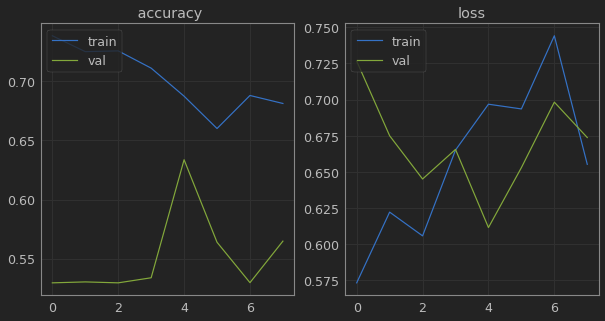

In [58]:
plot_training(model_history3)

In [38]:
acc = model3.evaluate(X_train_aug, Y_train_aug, verbose=1, batch_size=50)
print('Train score', acc[0])
print('Train accuracy', acc[1])

31468/31468 [==============================] - 14s 460us/step
Train score 0.356533714351
Train accuracy 0.817719583353


In [22]:
model4 = CNN_without_tl() #with generator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 74, 74, 32)        416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 18, 18, 64)        0         
__________

In [24]:
model4.fit_generator(
    gen_flow_without_inc_angles,
    steps_per_epoch=100,
    epochs=10,
    shuffle=True,
    verbose=1,
    validation_data=(Xdev, Ydev))

Epoch 1/10
100/100 [==============================] - 4s 40ms/step - loss: 0.6919 - acc: 0.5310 - val_loss: 0.6916 - val_acc: 0.5280
Epoch 2/10
100/100 [==============================] - 4s 38ms/step - loss: 0.6962 - acc: 0.5100 - val_loss: 0.6927 - val_acc: 0.5280
Epoch 3/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6920 - acc: 0.5340 - val_loss: 0.6927 - val_acc: 0.5280
Epoch 4/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6936 - acc: 0.5250 - val_loss: 0.6917 - val_acc: 0.5280
Epoch 5/10
100/100 [==============================] - 4s 38ms/step - loss: 0.6918 - acc: 0.5320 - val_loss: 0.6917 - val_acc: 0.5280
Epoch 6/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6922 - acc: 0.5313 - val_loss: 0.6927 - val_acc: 0.5280
Epoch 7/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6939 - acc: 0.5277 - val_loss: 0.6919 - val_acc: 0.5280
Epoch 8/10
100/100 [==============================] - 4s 39ms/step - 

## InceptionV3

In [59]:
def top_model(input_shape):
    input_img = Input(input_shape)
    X = GlobalAveragePooling2D()(input_img)
#     X = Flatten(input_shape=input_shape)(input_img)
    X = Dropout(0.2)(X)   
    
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)
#     X = Dense(512, activation='relu')(X)
#     X = Dropout(0.5)(X)
#     X = Dense(512, activation='relu')(X)
#     X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=input_img, outputs=X)
    
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',#optimizers.SGD(lr=1e-4, momentum=0.9),#'adam',
                 metrics=['accuracy'])
    
    return model

In [18]:
inception_model = InceptionV3(input_tensor=Input((75, 75, 3)), weights='imagenet', include_top=False)

In [20]:
inc_train_bf = inception_model.predict(X_train_aug, verbose=1)
inc_test_bf = inception_model.predict(X_test, verbose=1)

8424/8424 [==============================] - 20s 2ms/step


In [80]:
# Xtrain_data_bf, Xdev_data_bf, Ytrain_data_bf, Ydev_data_bf = train_test_split(inc_train_bf, Y_train, test_size=0.1, random_state=0)

In [98]:
# train_gen = gen.flow(Xtrain_data_bf, Ytrain_data_bf, batch_size=10, seed=5)
# dev_gen = gen.flow(Xdev_data_bf, Ydev_data_bf, batch_size=10, seed=5)

In [73]:
# bottleneck_features_train = inception_model.predict_generator(train_gen, 1400)#80% of train
# bottleneck_features_validation = inception_model.predict_generator(dev_gen, 160)


In [77]:
# bottleneck_features_train.shape

(13937, 1, 1, 2048)

In [60]:
inctop_model = top_model(inc_train_bf.shape[1:])

In [ ]:
# %%time
# model.fit_generator(
#     train_gen,
#     steps_per_epoch=32,
#     epochs=30,
#     shuffle=True,
#     verbose=1,
#     validation_data=(Xdev, Ydev)
# )

In [61]:
inc_history = inctop_model.fit(inc_train_bf, Y_train_aug, batch_size=100, epochs=20, validation_split=0.1,
             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 28321 samples, validate on 3147 samples
Epoch 1/20
28321/28321 [==============================] - 30s 1ms/step - loss: 0.5861 - acc: 0.7382 - val_loss: 0.4230 - val_acc: 0.7795
Epoch 2/20
28321/28321 [==============================] - 22s 770us/step - loss: 0.4428 - acc: 0.7690 - val_loss: 0.4127 - val_acc: 0.7846
Epoch 3/20
28321/28321 [==============================] - 22s 789us/step - loss: 0.4239 - acc: 0.7833 - val_loss: 0.3929 - val_acc: 0.8004
Epoch 4/20
28321/28321 [==============================] - 22s 788us/step - loss: 0.4112 - acc: 0.7900 - val_loss: 0.3854 - val_acc: 0.8049
Epoch 5/20
28321/28321 [==============================] - 22s 777us/step - loss: 0.4031 - acc: 0.7991 - val_loss: 0.3751 - val_acc: 0.8036
Epoch 6/20
28321/28321 [==============================] - 22s 787us/step - loss: 0.3948 - acc: 0.8000 - val_loss: 0.3725 - val_acc: 0.8106
Epoch 7/20
28321/28321 [==============================] - 22s 784us/step - loss: 0.3877 - acc: 0.8066 - val_loss: 0.376

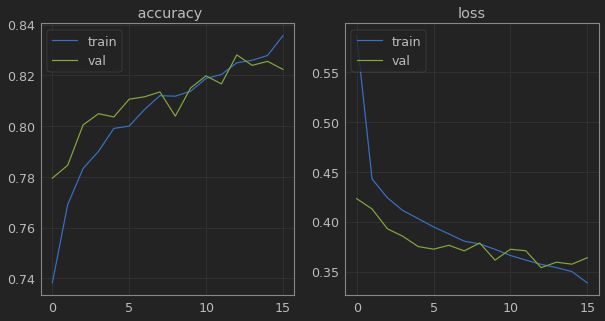

In [62]:
plot_training(inc_history)

In [63]:
inctop_model.save_weights('models/inctop_model.h5')

In [64]:
incx = inception_model.predict(X_train, verbose=1)
acc = inctop_model.evaluate(incx, Y_train, verbose=1, batch_size=50)
print('Train score', acc[0])
print('Train accuracy', acc[1])

1604/1604 [==============================] - 0s 131us/step
Train score 0.316170455995
Train accuracy 0.842892758121


## Fine tuning 

In [65]:
def ft_model(base_model, top_model_weights_path):
    
    top = top_model(base_model.output_shape[1:])
    top.load_weights(top_model_weights_path)
#     x = base_model.predict(X_train)
#     print(top.evaluate(x, Y_train))
    ft_model = Model(inputs=base_model.inputs, outputs=top(base_model.output))
    
    ft_model.compile(loss='binary_crossentropy',
                 optimizer=SGD(lr=1e-4, momentum=0.9),
                 metrics=['accuracy'])
    
    return ft_model
    

In [66]:
inception_model = InceptionV3(input_tensor=Input((75, 75, 3)), weights='imagenet', include_top=False)
for layer in inception_model.layers[:299]:
    layer.trainable = False

In [67]:
inc_ft_model = ft_model(inception_model, 'models/inctop_model.h5')

In [103]:
inc_ft_history = inc_ft_model.fit_generator(
    train_gen,
    steps_per_epoch=140,
    epochs=20,
    validation_data=dev_gen,
    validation_steps=16,
    callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Epoch 1/20
140/140 [==============================] - 24s 171ms/step - loss: 1.1375 - acc: 0.5202 - val_loss: 1.7894 - val_acc: 0.4688
Epoch 2/20
140/140 [==============================] - 11s 79ms/step - loss: 0.7849 - acc: 0.5093 - val_loss: 1.0200 - val_acc: 0.5625
Epoch 3/20
140/140 [==============================] - 11s 77ms/step - loss: 0.7700 - acc: 0.4912 - val_loss: 0.8723 - val_acc: 0.5000
Epoch 4/20
140/140 [==============================] - 11s 77ms/step - loss: 0.7298 - acc: 0.5362 - val_loss: 1.3200 - val_acc: 0.4313
Epoch 5/20
140/140 [==============================] - 11s 79ms/step - loss: 0.7257 - acc: 0.5355 - val_loss: 0.8140 - val_acc: 0.5313
Epoch 00005: early stopping


In [68]:
inc_ft_model2 = ft_model(inception_model, 'models/inctop_model.h5')

In [69]:
inc_history2 = inc_ft_model2.fit(X_train, Y_train, batch_size=10, epochs=20, validation_split=0.1,
             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 1443 samples, validate on 161 samples
Epoch 1/20
1443/1443 [==============================] - 28s 19ms/step - loss: 4.1718 - acc: 0.4962 - val_loss: 3.5665 - val_acc: 0.7329
Epoch 2/20
1443/1443 [==============================] - 13s 9ms/step - loss: 2.5817 - acc: 0.5087 - val_loss: 9.6482 - val_acc: 0.2174
Epoch 3/20
1443/1443 [==============================] - 14s 9ms/step - loss: 3.2390 - acc: 0.5336 - val_loss: 3.3312 - val_acc: 0.7826
Epoch 4/20
1443/1443 [==============================] - 13s 9ms/step - loss: 2.7881 - acc: 0.5329 - val_loss: 1.5842 - val_acc: 0.6087
Epoch 5/20
1443/1443 [==============================] - 14s 10ms/step - loss: 2.1666 - acc: 0.5447 - val_loss: 1.4511 - val_acc: 0.7888
Epoch 6/20
1443/1443 [==============================] - 14s 9ms/step - loss: 1.9781 - acc: 0.5918 - val_loss: 1.5978 - val_acc: 0.7702
Epoch 7/20
1443/1443 [==============================] - 13s 9ms/step - loss: 1.9544 - acc: 0.5773 - val_loss: 1.4415 - val_acc: 0.7578
Epoch 

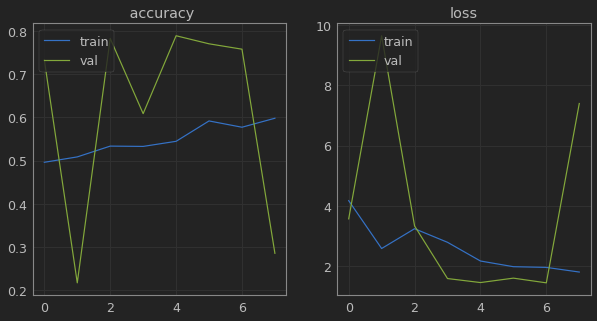

In [70]:
plot_training(inc_history2)

### prediction 

In [57]:
imgs = []
for i, row in test.iterrows():
    #make 75x75 image
    band_1 = np.array(row['band_1']).reshape(75, 75)
    band_2 = np.array(row['band_2']).reshape(75, 75)
    band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)

    # Rescale
    a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
    b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
    c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

    imgs.append(np.dstack((a, b, c)))
    
Xtest = np.array(imgs)

In [26]:
preds = inctop_model.predict(inc_test_bf)

In [27]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)